# 🏥 Type 2 Diabetes Predictor - Experiment with 9 Models

**Objective:** Train 9 models (3 algorithms × 3 datasets), compare them and select the best one.

- ✅ Logistic Regression (LR)
- ✅ Random Forest (RF)
- ✅ XGBoost (XGB)

Each on 3 datasets: M1, M2, M3

## 📦 Step 0: Imports and Configuration

In [1]:
import pandas as pd
import numpy as np
import pickle
import json
import warnings
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    accuracy_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## ⚙️ Step 1: Configure Paths and Parameters

In [2]:
# Configure paths
DATA_DIR = Path('../data/processed/')
MODELS_DIR = Path('../models/')
RESULTS_DIR = Path('../results/')

# Create directories if they don't exist
MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Datasets
DATASETS = ['m1', 'm2', 'm3']

# Define algorithms and configurations
ALGORITHMS = {
    'LR': LogisticRegression,
    'RF': RandomForestClassifier,
    'XGB': XGBClassifier,
}

CONFIGS = {
    'LR': {
        'max_iter': 1000,
        'solver': 'lbfgs',
        'class_weight': 'balanced',
        'random_state': 42,
    },
    'RF': {
        'n_estimators': 200,
        'max_depth': 15,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'class_weight': 'balanced',
        'n_jobs': -1,
        'random_state': 42,
    },
    'XGB': {
        'n_estimators': 200,
        'max_depth': 7,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'verbosity': 0,
        'use_label_encoder': False,
    }
}

print(f"✓ Paths configured:")
print(f"  Data: {DATA_DIR}")
print(f"  Models: {MODELS_DIR}")
print(f"  Results: {RESULTS_DIR}")
print(f"\n✓ Algorithms: {list(ALGORITHMS.keys())}")
print(f"✓ Datasets: {DATASETS}")

✓ Paths configured:
  Data: ..\data\processed
  Models: ..\models
  Results: ..\results

✓ Algorithms: ['LR', 'RF', 'XGB']
✓ Datasets: ['m1', 'm2', 'm3']


## 📊 Step 2: Load Data

In [3]:
# Load all datasets
loaded_data = {}

for dataset in DATASETS:
    train_path = DATA_DIR / f'{dataset}_train.parquet'
    test_path = DATA_DIR / f'{dataset}_test.parquet'
    
    df_train = pd.read_parquet(train_path)
    df_test = pd.read_parquet(test_path)
    
    X_train = df_train.drop('diabetes_dx', axis=1)
    y_train = df_train['diabetes_dx']
    X_test = df_test.drop('diabetes_dx', axis=1)
    y_test = df_test['diabetes_dx']
    
    loaded_data[dataset] = (X_train, y_train, X_test, y_test)
    
    print(f"✓ {dataset.upper()}:")
    print(f"  Train: {X_train.shape[0]} samples, {X_train.shape[1]} features")
    print(f"  Test:  {X_test.shape[0]} samples")
    print(f"  Class balance (train): {y_train.value_counts().to_dict()}\n")

✓ M1:
  Train: 45916 samples, 8 features
  Test:  11479 samples
  Class balance (train): {0: 42054, 1: 3862}

✓ M2:
  Train: 45916 samples, 16 features
  Test:  11479 samples
  Class balance (train): {0: 42054, 1: 3862}

✓ M3:
  Train: 45916 samples, 8 features
  Test:  11479 samples
  Class balance (train): {0: 42054, 1: 3862}



## 🚀 Step 3: Function to Train a Single Model

In [4]:
def train_single_model(X_train, y_train, X_test, y_test, algo_name, cv_folds=5):
    """
    Train a single model with cross-validation and test evaluation.
    
    Returns:
        - model: Model trained on full Xtrain
        - cv_results: Dict with cross-validation results
        - test_metrics: Dict with metrics on test set
    """
    print(f"\n{'='*70}")
    print(f"Training {algo_name}")
    print(f"{'='*70}")
    
    # Create model
    config = CONFIGS[algo_name].copy()
    
    # For XGBoost, calculate scale_pos_weight based on real imbalance
    if algo_name == 'XGB':
        imbalance_ratio = y_train[y_train == 0].sum() / y_train[y_train == 1].sum()
        config['scale_pos_weight'] = imbalance_ratio
        print(f"Class imbalance ratio: {imbalance_ratio:.2f}")
    
    ModelClass = ALGORITHMS[algo_name]
    model = ModelClass(**config)
    
    # Cross-validation
    print(f"\nCross-validation {cv_folds}-fold...")
    cv_splitter = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    cv_results = cross_validate(
        model, X_train, y_train,
        cv=cv_splitter,
        scoring={'roc_auc': 'roc_auc', 'f1': 'f1', 'precision': 'precision', 'recall': 'recall', 'accuracy': 'accuracy'},
        return_train_score=False,
        n_jobs=-1 if algo_name != 'LR' else 1
    )
    
    print(f"CV AUC-ROC: {cv_results['test_roc_auc'].mean():.4f} ± {cv_results['test_roc_auc'].std():.4f}")
    print(f"CV F1-Score: {cv_results['test_f1'].mean():.4f} ± {cv_results['test_f1'].std():.4f}")
    print(f"CV Precision: {cv_results['test_precision'].mean():.4f} ± {cv_results['test_precision'].std():.4f}")
    print(f"CV Recall: {cv_results['test_recall'].mean():.4f} ± {cv_results['test_recall'].std():.4f}")
    
    # Train on full train set
    print(f"\nTraining on full train set ({X_train.shape[0]} samples)...")
    model.fit(X_train, y_train)
    print(f"✓ Complete")
    
    # Evaluate on test set
    print(f"\nEvaluating on test set ({X_test.shape[0]} samples)...")
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    test_metrics = {
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'f1': f1_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred),
    }
    
    # Calculate specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    test_metrics['specificity'] = tn / (tn + fp)
    
    print(f"\n{'='*70}")
    print(f"TEST METRICS:")
    print(f"  AUC-ROC:    {test_metrics['roc_auc']:.4f}")
    print(f"  F1-Score:   {test_metrics['f1']:.4f}")
    print(f"  Precision:  {test_metrics['precision']:.4f}")
    print(f"  Recall:     {test_metrics['recall']:.4f}")
    print(f"  Accuracy:   {test_metrics['accuracy']:.4f}")
    print(f"  Specificity: {test_metrics['specificity']:.4f}")
    print(f"{'='*70}")
    
    return model, cv_results, test_metrics

## ⚡ Step 4: Train 9 Models (3×3 Grid)

In [5]:
# Store results
results_list = []
trained_models = {}

# Train all models
for dataset in DATASETS:
    X_train, y_train, X_test, y_test = loaded_data[dataset]
    
    print(f"\n\n{'#'*70}")
    print(f"# DATASET {dataset.upper()}")
    print(f"{'#'*70}")
    
    for algo_name in ALGORITHMS.keys():
        # Train model
        model, cv_results, test_metrics = train_single_model(
            X_train, y_train, X_test, y_test, algo_name, cv_folds=5
        )
        
        # Save model
        model_path = MODELS_DIR / f'{dataset}_{algo_name.lower()}.pkl'
        with open(model_path, 'wb') as f:
            pickle.dump(model, f)
        print(f"✓ Model saved: {model_path}")
        
        # Store in dictionary
        trained_models[f'{dataset}_{algo_name}'] = model
        
        # Add to results
        result_row = {
            'dataset': dataset.upper(),
            'algorithm': algo_name,
            'n_features': X_train.shape[1],
            'cv_auc_mean': cv_results['test_roc_auc'].mean(),
            'cv_auc_std': cv_results['test_roc_auc'].std(),
            'cv_f1_mean': cv_results['test_f1'].mean(),
            'cv_f1_std': cv_results['test_f1'].std(),
            'test_auc': test_metrics['roc_auc'],
            'test_f1': test_metrics['f1'],
            'test_precision': test_metrics['precision'],
            'test_recall': test_metrics['recall'],
            'test_accuracy': test_metrics['accuracy'],
            'test_specificity': test_metrics['specificity'],
        }
        results_list.append(result_row)

print("\n\n✓ All 9 models trained successfully!")



######################################################################
# DATASET M1
######################################################################

Training LR

Cross-validation 5-fold...
CV AUC-ROC: 0.7740 ± 0.0050
CV F1-Score: 0.2906 ± 0.0029
CV Precision: 0.1856 ± 0.0020
CV Recall: 0.6696 ± 0.0154

Training on full train set (45916 samples)...
✓ Complete

Evaluating on test set (11479 samples)...

TEST METRICS:
  AUC-ROC:    0.7733
  F1-Score:   0.2818
  Precision:  0.1802
  Recall:     0.6466
  Accuracy:   0.7230
  Specificity: 0.7300
✓ Model saved: ..\models\m1_lr.pkl

Training RF

Cross-validation 5-fold...
CV AUC-ROC: 0.7857 ± 0.0078
CV F1-Score: 0.3237 ± 0.0118
CV Precision: 0.2634 ± 0.0078
CV Recall: 0.4200 ± 0.0215

Training on full train set (45916 samples)...
✓ Complete

Evaluating on test set (11479 samples)...

TEST METRICS:
  AUC-ROC:    0.7971
  F1-Score:   0.3354
  Precision:  0.2678
  Recall:     0.4487
  Accuracy:   0.8505
  Specificity: 0.8874
✓ Model save

## 📈 Step 5: Results Summary

In [6]:
# Create DataFrame with results
results_df = pd.DataFrame(results_list)

# Sort by dataset and algorithm
dataset_order = {'M1': 0, 'M2': 1, 'M3': 2}
algo_order = {'LR': 0, 'RF': 1, 'XGB': 2}

results_df['dataset_order'] = results_df['dataset'].map(dataset_order)
results_df['algo_order'] = results_df['algorithm'].map(algo_order)
results_df = results_df.sort_values(['dataset_order', 'algo_order']).drop(['dataset_order', 'algo_order'], axis=1)

# Display full table
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print("\n" + "="*150)
print("TRAINING COMPLETE - SUMMARY TABLE")
print("="*150 + "\n")
print(results_df.to_string(index=False))
print("\n" + "="*150)

# Save summary
summary_path = RESULTS_DIR / 'metrics_summary.csv'
results_df.to_csv(summary_path, index=False)
print(f"\n✓ Summary saved: {summary_path}")


TRAINING COMPLETE - SUMMARY TABLE

dataset algorithm  n_features  cv_auc_mean  cv_auc_std  cv_f1_mean  cv_f1_std  test_auc  test_f1  test_precision  test_recall  test_accuracy  test_specificity
     M1        LR           8     0.774029    0.005016    0.290574   0.002929  0.773266 0.281843        0.180191     0.646632       0.722972          0.729979
     M1        RF           8     0.785672    0.007763    0.323704   0.011811  0.797113 0.335399        0.267780     0.448705       0.850510          0.887388
     M1       XGB           8     0.500000    0.000000    0.000000   0.000000  0.500000 0.000000        0.000000     0.000000       0.915933          1.000000
     M2        LR          16     0.928919    0.006649    0.571182   0.009555  0.934030 0.581582        0.460654     0.788601       0.904608          0.915256
     M2        RF          16     0.938189    0.007296    0.656545   0.013115  0.944965 0.664781        0.609862     0.730570       0.938061          0.957105
     M2   

## 📊 Step 6: Visual Comparison

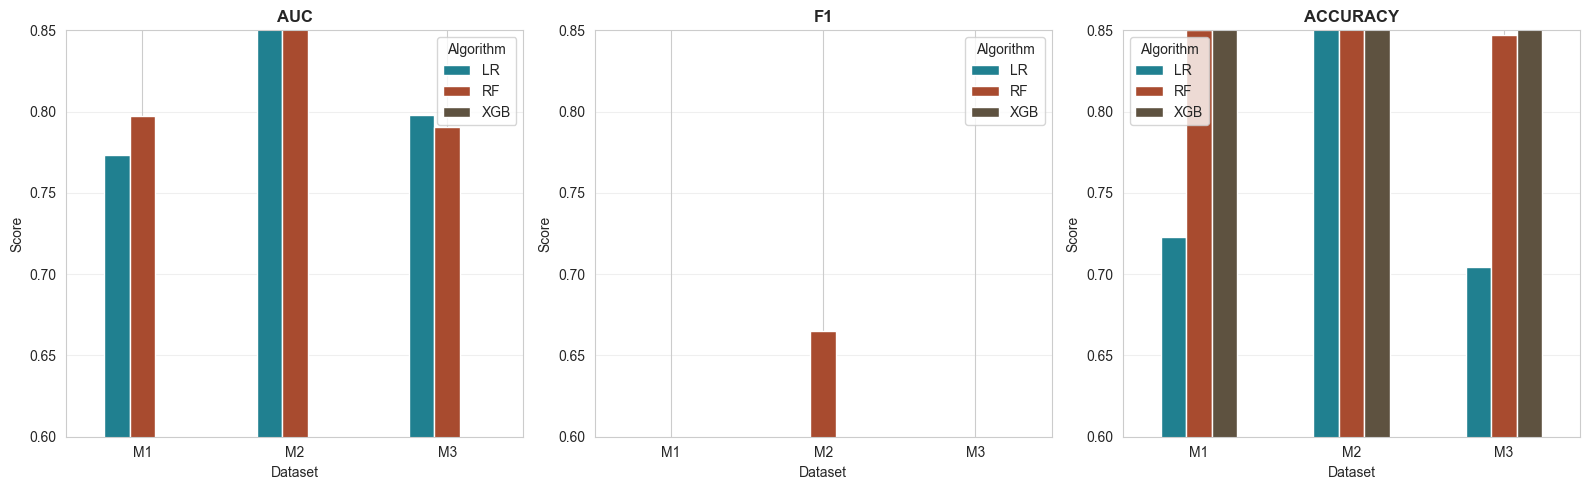

✓ Plot saved: comparison_metrics.png


In [7]:
# Plot: Comparison of Test metrics by algorithm
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, metric in enumerate(['test_auc', 'test_f1', 'test_accuracy']):
    pivot_data = results_df.pivot(index='dataset', columns='algorithm', values=metric)
    pivot_data.plot(kind='bar', ax=axes[idx], color=['#208090', '#a84b2f', '#5e5240'])
    axes[idx].set_title(metric.replace('test_', '').upper(), fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Score')
    axes[idx].set_xlabel('Dataset')
    axes[idx].legend(title='Algorithm')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_ylim([0.6, 0.85])
    axes[idx].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'comparison_metrics.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Plot saved: comparison_metrics.png")

## 🏆 Step 7: Select the Best Model

In [8]:
# Show models sorted by Test AUC
print("\n" + "="*100)
print("TOP 5 MODELS BY TEST AUC")
print("="*100 + "\n")
top_models = results_df.nlargest(5, 'test_auc')[['dataset', 'algorithm', 'test_auc', 'test_f1', 'test_accuracy', 'test_precision', 'test_recall', 'test_specificity']]
print(top_models.to_string(index=False))
print("\n" + "="*100)

# Best model
best_idx = results_df['test_auc'].idxmax()
best_model_row = results_df.iloc[best_idx]

print(f"\n🏆 BEST MODEL: {best_model_row['dataset']} - {best_model_row['algorithm']}")
print(f"   Test AUC: {best_model_row['test_auc']:.4f}")
print(f"   Test F1: {best_model_row['test_f1']:.4f}")
print(f"   Test Accuracy: {best_model_row['test_accuracy']:.4f}")


TOP 5 MODELS BY TEST AUC

dataset algorithm  test_auc  test_f1  test_accuracy  test_precision  test_recall  test_specificity
     M2        RF  0.944965 0.664781       0.938061        0.609862     0.730570          0.957105
     M2        LR  0.934030 0.581582       0.904608        0.460654     0.788601          0.915256
     M3        LR  0.798012 0.294216       0.704504        0.184067     0.732642          0.701921
     M1        RF  0.797113 0.335399       0.850510        0.267780     0.448705          0.887388
     M3        RF  0.790484 0.317757       0.847373        0.254523     0.422798          0.886342


🏆 BEST MODEL: M2 - RF
   Test AUC: 0.9450
   Test F1: 0.6648
   Test Accuracy: 0.9381


## 🔬 Step 8: Analyze Best Model

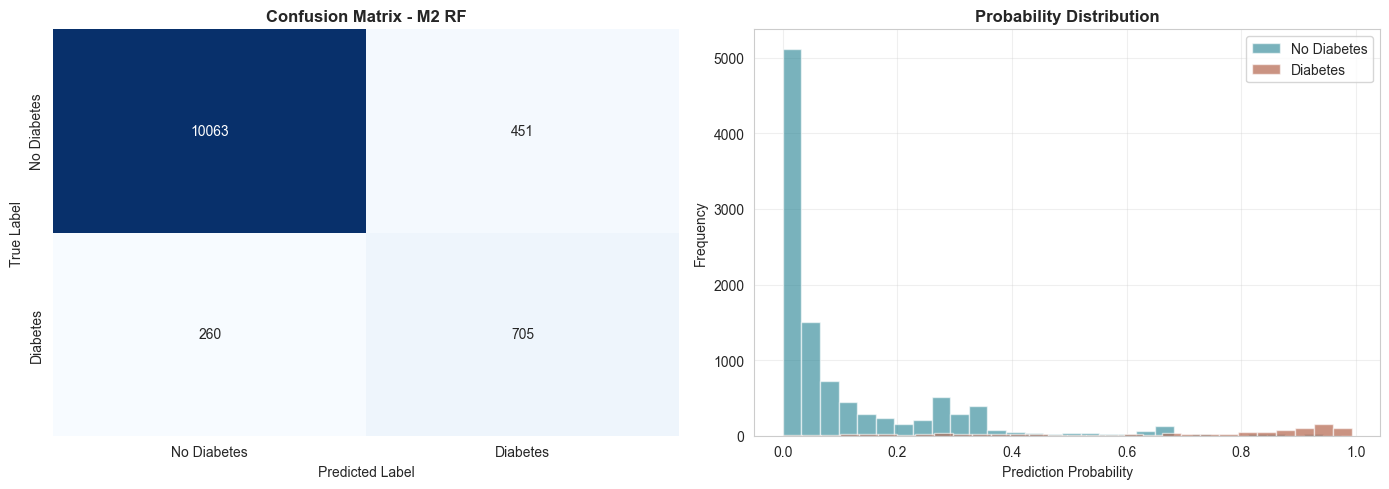

✓ Analysis saved: best_model_analysis.png


In [10]:
# Load best model
best_model_key = f"{best_dataset}_{best_algorithm}"
best_model = trained_models[best_model_key]

# Load data for best model
X_train, y_train, X_test, y_test = loaded_data[best_dataset]

# Predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False,
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
axes[0].set_title(f'Confusion Matrix - {best_model_row["dataset"]} {best_algorithm}', fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Prediction Probability Distribution
axes[1].hist(y_pred_proba[y_test == 0], bins=30, alpha=0.6, label='No Diabetes', color='#208090')
axes[1].hist(y_pred_proba[y_test == 1], bins=30, alpha=0.6, label='Diabetes', color='#a84b2f')
axes[1].set_xlabel('Prediction Probability')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Probability Distribution', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'best_model_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Analysis saved: best_model_analysis.png")

## 📊 Step 9: Feature Importance


Top 15 Features for M2 - RF:

                feature  importance
          hba1c_percent    0.462983
               waist_cm    0.088091
                    whr    0.083350
                    bmi    0.056876
              height_cm    0.037307
family_history_diabetes    0.035247
        creatinine_mgdl    0.035110
                non_hdl    0.028176
        chol_total_mgdl    0.027591
                carbs_g    0.027458
         smoking_status    0.026963
              protein_g    0.022273
               hdl_mgdl    0.022099
                  fat_g    0.021894
          poverty_ratio    0.021743


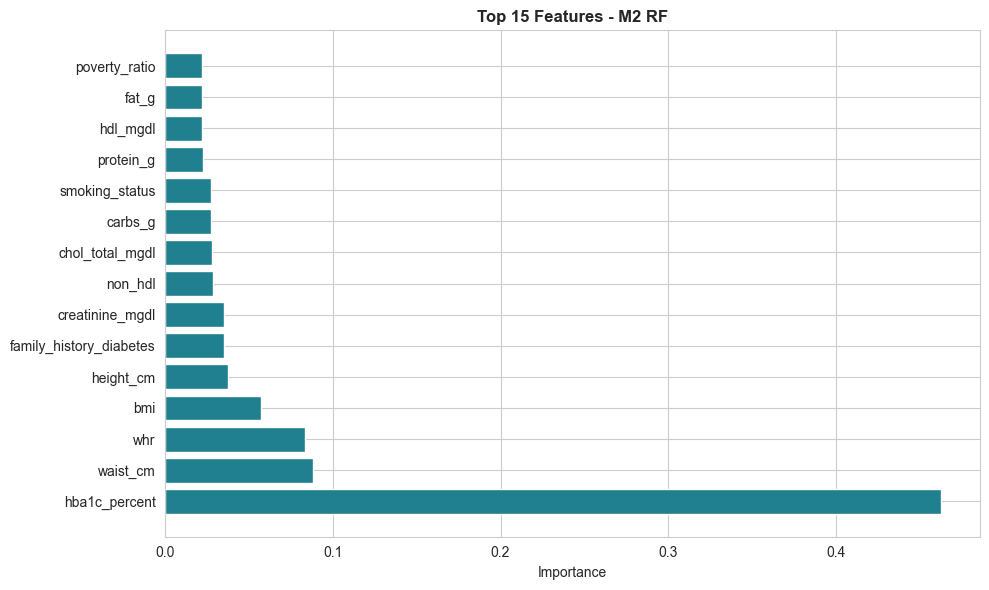


✓ Feature importance saved: feature_importance.png


In [12]:
# Feature Importance (available for RF and XGB)
if best_algorithm in ['RF', 'XGB']:
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 15 Features for {best_model_row['dataset']} - {best_algorithm}:\n")
    print(feature_importance.head(15).to_string(index=False))
    
    # Plot
    plt.figure(figsize=(10, 6))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'].values, color='#208090')
    plt.yticks(range(len(top_features)), top_features['feature'].values)
    plt.xlabel('Importance')
    plt.title(f'Top 15 Features - {best_model_row["dataset"]} {best_algorithm}', fontweight='bold')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'feature_importance.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Feature importance saved: feature_importance.png")
else:
    print(f"\n⚠️  Feature importance not available for {best_algorithm}")
    print(f"   (Available only for Random Forest and XGBoost)")